In [1]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pylab inline
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
%matplotlib inline
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from tensorflow import keras
from datetime import datetime

sns.set(rc={'figure.figsize':(12,8)})

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
'''BASELINE'''

df = pd.read_csv('/content/drive/My Drive/data-mortgage/data_CB_jan.csv',',', index_col=['Date'], parse_dates=['Date'], dayfirst=True, encoding='cp1251')
df = df[8:]
values = DataFrame(df.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
X = dataframe.values
train_size = int(len(X) * 0.7)
Train, Test = X[1:train_size], X[train_size:]
train_X, train_y = Train[:,0], Train[:,1]
test_X, test_y = Test[:,0], Test[:,1]

def model_persistence(x):
    return x


predictions_base = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions_base.append(yhat)
test_score = mean_squared_error(test_y, predictions_base)
predictions_base = pd.DataFrame(data={'baseline':predictions_base})
test = df[int(len(df)*0.7):]
predictions_base = predictions_base.set_index(pd.DatetimeIndex(test.index))
mape_base = round(mean_absolute_percentage_error(test, predictions_base.baseline), 2)

In [4]:
'''ARIMA'''
train = df[:int(len(df)*0.7)]
test = df[int(len(df)*0.7):]
X = train.Money
result = adfuller(X)
if  result[1] > 0.05:
  d = 1
else:
  d = 0

# sm.graphics.tsa.plot_acf(train)
# sm.graphics.tsa.plot_pacf(train)
# plt.show()

In [5]:
ps = [0, 1, 4, 9, 12, 13]
qs = range(0, 5)

parameters = product(ps, qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 30


In [6]:
# for parameter in parameters_list:
#     mod = sm.tsa.ARMA(train.Money.dropna(), order=(parameter[0], parameter[1]))
#     res = mod.fit();
#     print("Order: {}\nBIC: {}\nAIC: {}\n".format((parameter[0], parameter[1]), res.bic, res.aic))

In [7]:
X = df.values
size = int(len(X) * 0.7)
trainn, testt = X[0:size], X[size:len(X)]
history = [x for x in trainn]
predictions = []
for t in range(len(testt)):
    model = sm.tsa.ARIMA(history, order=(1,d,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = testt[t]
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
pred = []
for i in range(len(predictions)):
    for j in range(len(predictions[i])):
        pred.append(predictions[i][j])

pred_arima = pd.DataFrame(data={'pred':pred})
pred_arima = pred_arima.set_index(pd.DatetimeIndex(test.index))
mape_arima = round(mean_absolute_percentage_error(test, pred_arima), 2)

In [8]:
'''LSTM'''
size = int(len(df) * 0.7)
df_val = df.values
df_val = df_val.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
df_val = scaler.fit_transform(df_val)
w_len = 1
df_train, df_test = df_val[0:size, :], df_val[(size-w_len):len(df_val), :]
np.random.seed(7)

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        b = dataset[i+look_back, 0]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(df_train, look_back=w_len)
testX, testY = create_dataset(df_test, look_back=w_len)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

BATCH_SIZE = 72

model = Sequential()
model.add(LSTM(500, input_shape=(1, w_len), return_sequences=True))
model.add(LSTM(500))
model.add(Dense(1))
#adam = keras.optimizers.Adam(lr=4e-5)
model.compile(loss='mae', optimizer='adam')
model.fit(trainX, trainY, epochs = 50, batch_size=BATCH_SIZE, verbose=2, validation_split=0.3)
# model.save('lstm_01_06_2021.h5')
model = keras.models.load_model('lstm_01_06_2021.h5')

Epoch 1/50
1/1 - 17s - loss: 0.1789 - val_loss: 0.1997
Epoch 2/50
1/1 - 0s - loss: 0.1662 - val_loss: 0.1864
Epoch 3/50
1/1 - 0s - loss: 0.1538 - val_loss: 0.1746
Epoch 4/50
1/1 - 0s - loss: 0.1422 - val_loss: 0.1655
Epoch 5/50
1/1 - 0s - loss: 0.1292 - val_loss: 0.1551
Epoch 6/50
1/1 - 0s - loss: 0.1168 - val_loss: 0.1433
Epoch 7/50
1/1 - 0s - loss: 0.1032 - val_loss: 0.1329
Epoch 8/50
1/1 - 0s - loss: 0.0892 - val_loss: 0.1249
Epoch 9/50
1/1 - 0s - loss: 0.0779 - val_loss: 0.1189
Epoch 10/50
1/1 - 0s - loss: 0.0752 - val_loss: 0.1204
Epoch 11/50
1/1 - 0s - loss: 0.0781 - val_loss: 0.1236
Epoch 12/50
1/1 - 0s - loss: 0.0850 - val_loss: 0.1263
Epoch 13/50
1/1 - 0s - loss: 0.0885 - val_loss: 0.1261
Epoch 14/50
1/1 - 0s - loss: 0.0882 - val_loss: 0.1239
Epoch 15/50
1/1 - 0s - loss: 0.0850 - val_loss: 0.1220
Epoch 16/50
1/1 - 0s - loss: 0.0807 - val_loss: 0.1198
Epoch 17/50
1/1 - 0s - loss: 0.0771 - val_loss: 0.1188
Epoch 18/50
1/1 - 0s - loss: 0.0759 - val_loss: 0.1195
Epoch 19/50
1/1 - 

In [9]:
predictions_lstm = list()
for t in range(len(testX)):
    X = testX[t]
    yhat = model.predict(np.reshape(X, (1,1,w_len)))
    predictions_lstm.append(yhat[0])
    expected = testX[t][0]

In [10]:
testPredict = scaler.inverse_transform([np.concatenate(predictions_lstm)])
testY = np.hstack(testY)
testY = scaler.inverse_transform([np.concatenate([np.expand_dims(i,axis=0) for i in testY])])

In [11]:
predicted_lstm = pd.DataFrame(testPredict[0])
test_df = pd.DataFrame(testY[0])
mape_lstm = round(mean_absolute_percentage_error(testY, testPredict), 2)

In [12]:
'''Transfer Learning'''
df_aux = pd.read_csv('/content/drive/My Drive/data-mortgage/usd.csv')
df_aux = df_aux.fillna(df_aux.mean())

df_aux['Date'] = pd.to_datetime(df_aux['Date'])
df_aux = df_aux.resample('D', on='Date').sum()

size_aux = int(len(df_aux) * 0.7)
df_val_aux = df_aux.Close
df_val_aux = df_val_aux.astype('float32')
scaler_aux = MinMaxScaler(feature_range=(0, 1))
df_val_aux = np.array([df_val_aux]).reshape(-1, 1)
df_val_aux = scaler_aux.fit_transform(df_val_aux)
w_len = 1
df_train_aux, df_test_aux = df_val_aux[0:size_aux, :], df_val_aux[(size_aux-w_len):len(df_val_aux), :]

trainX_aux, trainY_aux = create_dataset(df_train_aux, look_back=w_len)
testX_aux, testY_aux = create_dataset(df_test_aux, look_back=w_len)

trainX_aux = np.reshape(trainX_aux, (trainX_aux.shape[0], 1, trainX_aux.shape[1]))
testX_aux = np.reshape(testX_aux, (testX_aux.shape[0], 1, testX_aux.shape[1]))

In [13]:
BATCH_SIZE = 72

model_aux = Sequential()
model_aux.add(LSTM(500, input_shape=(1, w_len), return_sequences=True))
model_aux.add(LSTM(500))
model_aux.add(Dense(1))
model_aux.compile(loss='mae', optimizer='adam')
model_aux.fit(trainX_aux, trainY_aux, epochs = 50, batch_size=BATCH_SIZE, verbose=2, validation_split=0.3)

Epoch 1/50
9/9 - 4s - loss: 0.4953 - val_loss: 0.4318
Epoch 2/50
9/9 - 0s - loss: 0.3083 - val_loss: 0.3086
Epoch 3/50
9/9 - 0s - loss: 0.2542 - val_loss: 0.2727
Epoch 4/50
9/9 - 0s - loss: 0.2371 - val_loss: 0.2469
Epoch 5/50
9/9 - 0s - loss: 0.2256 - val_loss: 0.2439
Epoch 6/50
9/9 - 0s - loss: 0.2248 - val_loss: 0.2413
Epoch 7/50
9/9 - 0s - loss: 0.2259 - val_loss: 0.2373
Epoch 8/50
9/9 - 0s - loss: 0.2346 - val_loss: 0.2401
Epoch 9/50
9/9 - 0s - loss: 0.2296 - val_loss: 0.2409
Epoch 10/50
9/9 - 0s - loss: 0.2276 - val_loss: 0.2395
Epoch 11/50
9/9 - 0s - loss: 0.2287 - val_loss: 0.2492
Epoch 12/50
9/9 - 0s - loss: 0.2251 - val_loss: 0.2437
Epoch 13/50
9/9 - 0s - loss: 0.2242 - val_loss: 0.2466
Epoch 14/50
9/9 - 0s - loss: 0.2245 - val_loss: 0.2477
Epoch 15/50
9/9 - 0s - loss: 0.2249 - val_loss: 0.2474
Epoch 16/50
9/9 - 0s - loss: 0.2256 - val_loss: 0.2421
Epoch 17/50
9/9 - 0s - loss: 0.2235 - val_loss: 0.2446
Epoch 18/50
9/9 - 0s - loss: 0.2235 - val_loss: 0.2349
Epoch 19/50
9/9 - 0

In [14]:
df = pd.read_csv('/content/drive/My Drive/data-mortgage/data_CB_jan.csv', index_col='Date')
df = df[8:]
size = int(len(df) * 0.7)
df_val = df.values
df_val = df_val.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
df_val = scaler.fit_transform(df_val)
w_len = 1
df_train, df_test = df_val[0:size, :], df_val[(size-w_len):len(df_val), :]
len(df), len(df_train), len(df_test)

(32, 22, 11)

In [15]:
trainX, trainY = create_dataset(df_train, look_back=w_len)
testX, testY = create_dataset(df_test, look_back=w_len)

In [16]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

BATCH_SIZE = 72

model = Sequential()
model.add(LSTM(500, input_shape=(1, w_len), return_sequences=True))
model.add(LSTM(500))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

model.set_weights(weights = model_aux.get_weights()) 

model.fit(trainX, trainY, epochs = 50, batch_size=BATCH_SIZE, verbose=2, validation_split=0.3)
# model.save('transfer_02_06_2021.h5')
model = keras.models.load_model('transfer_02_06_2021.h5')

Epoch 1/50
1/1 - 3s - loss: 0.0879 - val_loss: 0.1461
Epoch 2/50
1/1 - 0s - loss: 0.0732 - val_loss: 0.1547
Epoch 3/50
1/1 - 0s - loss: 0.0729 - val_loss: 0.1596
Epoch 4/50
1/1 - 0s - loss: 0.0768 - val_loss: 0.1593
Epoch 5/50
1/1 - 0s - loss: 0.0775 - val_loss: 0.1562
Epoch 6/50
1/1 - 0s - loss: 0.0748 - val_loss: 0.1520
Epoch 7/50
1/1 - 0s - loss: 0.0730 - val_loss: 0.1476
Epoch 8/50
1/1 - 0s - loss: 0.0714 - val_loss: 0.1429
Epoch 9/50
1/1 - 0s - loss: 0.0722 - val_loss: 0.1413
Epoch 10/50
1/1 - 0s - loss: 0.0734 - val_loss: 0.1406
Epoch 11/50
1/1 - 0s - loss: 0.0741 - val_loss: 0.1401
Epoch 12/50
1/1 - 0s - loss: 0.0744 - val_loss: 0.1397
Epoch 13/50
1/1 - 0s - loss: 0.0743 - val_loss: 0.1396
Epoch 14/50
1/1 - 0s - loss: 0.0739 - val_loss: 0.1396
Epoch 15/50
1/1 - 0s - loss: 0.0733 - val_loss: 0.1397
Epoch 16/50
1/1 - 0s - loss: 0.0724 - val_loss: 0.1415
Epoch 17/50
1/1 - 0s - loss: 0.0716 - val_loss: 0.1434
Epoch 18/50
1/1 - 0s - loss: 0.0717 - val_loss: 0.1451
Epoch 19/50
1/1 - 0

In [17]:
predictions_transfer = list()
for t in range(len(testX)):
    X = testX[t]
    yhat = model.predict(np.reshape(X, (1,1,w_len)))
    predictions_transfer.append(yhat[0])
    expected = testX[t][0]

In [18]:
testPredict = scaler.inverse_transform([np.concatenate(predictions_transfer)])
testY = np.hstack(testY)
testY = scaler.inverse_transform([np.concatenate([np.expand_dims(i,axis=0) for i in testY])])

In [19]:
predicted_transfer = pd.DataFrame(testPredict[0])
mape_transfer = round(mean_absolute_percentage_error(testY, testPredict), 2)

In [20]:
predict_s_new_point = [df.Money[len(df_train)-1]]
for i in range(len(predictions)):
  predict_s_new_point.append(predictions[i])

predict_s_new_point = pd.DataFrame({'ARIMA': predict_s_new_point})
predict_s_new_point = predict_s_new_point.set_index(df.Money[len(df_train)-1:].index)

predictions_new_point = [df.Money[len(df_train)-1]]
for i in range(len(predictions_base)):
  predictions_new_point.append(predictions_base.values[i])

predictions_new_point = pd.DataFrame({'Baseline': predictions_new_point})
predictions_new_point = predictions_new_point.set_index(df.Money[len(df_train)-1:].index)

predictions_noTrans_new_point = [df.Money[len(df_train)-1]]
for i in range(len(predicted_lstm)):
  predictions_noTrans_new_point.append(predicted_lstm.values[i])

predictions_noTrans_new_point = pd.DataFrame({'LSTM': predictions_noTrans_new_point})
predictions_noTrans_new_point = predictions_noTrans_new_point.set_index(df.Money[len(df_train)-1:].index)

predictions_withTrans_new_point = [df.Money[len(df_train)-1]]
for i in range(len(predicted_transfer)):
  predictions_withTrans_new_point.append(predicted_transfer.values[i])

predictions_withTrans_new_point = pd.DataFrame({'LSTM': predictions_withTrans_new_point})
predictions_withTrans_new_point = predictions_withTrans_new_point.set_index(df.Money[len(df_train)-1:].index)

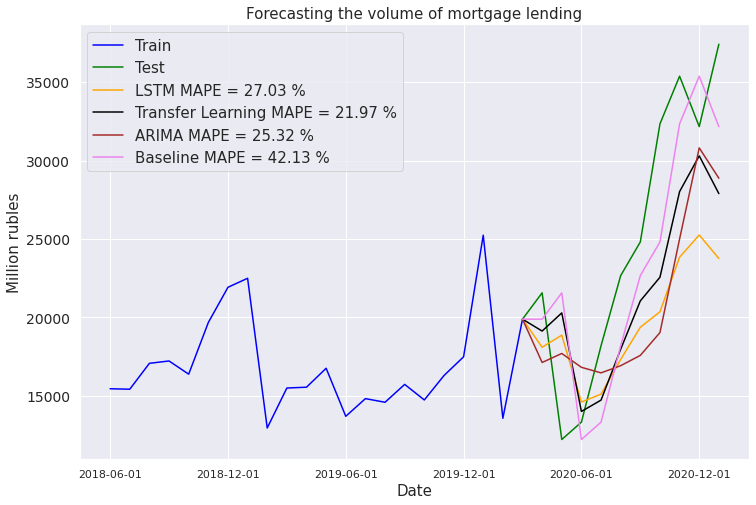

In [21]:
plt.plot(df.Money[:len(trainn)], color='blue', label='Train')
plt.plot(df[len(trainn)-1:], color='green', label='Test')

plt.plot(predictions_noTrans_new_point, color='orange', label=f'LSTM MAPE = {mape_lstm} %')
plt.plot(predictions_withTrans_new_point, color='black', label=f'Transfer Learning MAPE = {mape_transfer} %')


plt.plot(predict_s_new_point, color='brown',  label=f"ARIMA MAPE = {mape_arima} %")
plt.plot(predictions_new_point, color='violet', label=f'Baseline MAPE = {mape_base} %')

plt.yticks(fontsize=14)
plt.xticks(df.index[0:-1:6])

plt.title('Forecasting the volume of mortgage lending', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Million rubles', fontsize=15)
plt.legend(fontsize=15)
# plt.savefig('arima-base-lstm-transfer-eng.png', dpi=300)